# NN.TRANSFORMER 와 TORCHTEXT 로 시퀀스-투-시퀀스(SEQUENCE-TO-SEQUENCE) 모델링하기

이 튜토리얼에서는 [nn.Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) 모듈을 이용하는 `시퀀스-투-시퀀스(Sequence-to-Sequence) 모델을 학습`하는 방법을 배워보겠습니다.

PyTorch 1.2 버젼에는 **`Attention is All You Need** 논문에 기반한 표준 트랜스포머(transformer) 모듈을 포함`하고 있습니다. 트랜스포머 모델은 더 높은 수준의 병렬화(parallelization)가 가능하면서도 많은 시퀀스-투-시퀀스 문제들에서 품질이 우수함이 입증되었습니다.

`nn.Transformer` 모듈은 입력(input) 과 출력(output) 사이의 전역적인 의존성(global dependencies) 을 나타내기 위하여 전적으로 `어텐션(attention) 메커니즘에 의존`합니다. (최근에 또 다른 모듈이 `nn.MultiheadAttention` 으로 구현되었습니다.) nn.Transformer 모듈은 현재 모듈화가 매우 잘 되어 있어, 다음과 같은 단일 컴포넌트 (이 튜토리얼의 nn.TransformerEncoder 와 같은) 는 쉽게 적용 및 구성될 수 있습니다.

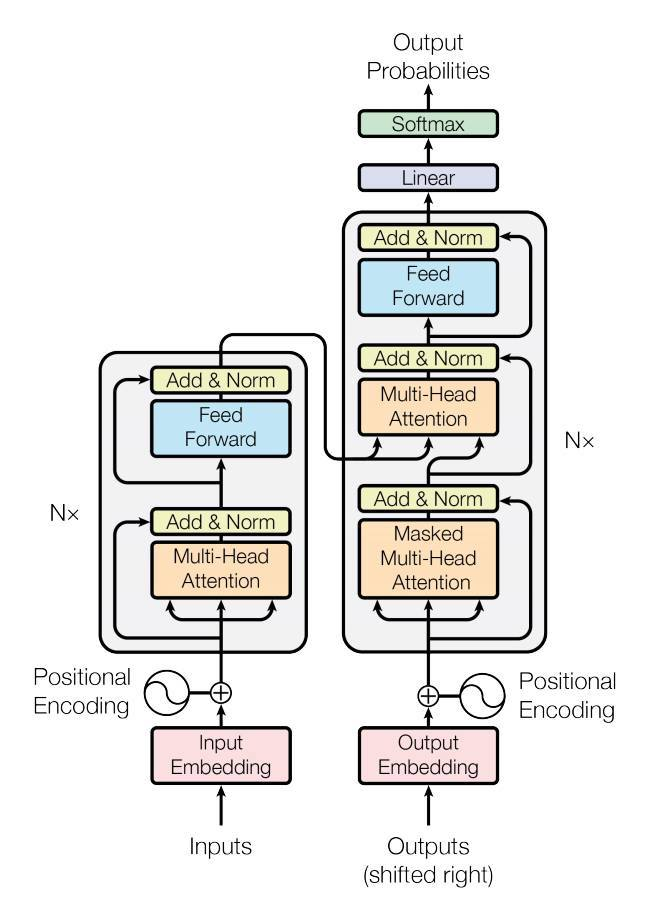

## 모델 정의하기

이 튜토리얼에서, 우리는 `nn.TransformerEncoder` 모델을 언어 모델링(language modeling) 과제에 대해서 학습시킬 것입니다.

언어 모델링 과제는 `주어진 단어 (또는 단어의 시퀀스) 가 다음에 이어지는 단어 시퀀스를 따를 가능성(likelihood)에 대한 확률을 할당`하는 것입니다. 

먼저, `토큰(token) 들의 시퀀스`가 임베딩(embedding) 레이어로 전달되며, 이어서 포지셔널 인코딩(positional encoding) 레이어가 각 단어의 순서를 설명합니다. (더 자세한 설명은 다음 단락을 참고해주세요.) 

`nn.TransformerEncoder` 는 `여러 개의 nn.TransformerEncoderLayer 레이어로 구성`되어 있습니다. nn.TransformerEncoder 내부의 셀프-어텐션(self-attention) 레이어들은 시퀀스 안에서의 이전 포지션에만 집중하도록 허용되기 때문에, `입력(input) 순서`와 함께, `정사각 형태의 어텐션 마스크(attention mask) 가 필요`합니다. 

언어 모델링 과제를 위해서, 미래의 포지션에 있는 모든 토큰들은 `마스킹` 되어야(가려져야) 합니다. 실제 단어를 얻기 위해서, nn.TransformerEncoder 의 `출력은 로그-소프트맥스(log-Softmax) 로 이어지는 최종 선형(Linear) 레이어로 전달`됩니다.

In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

C:\Users\bini\anaconda3\envs\anaconda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bini\anaconda3\envs\anaconda\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\bini\anaconda3\envs\anaconda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


Tutorial에서 Transformer의 구조가 논문과 다른 부분들이 조금 있는데, Task가 다르기 때문에 발생한 차이이다. 우선 `Output이 가장 등장 확률이 높은 단어 하나` 이기 때문에 Decoder의 형태를 띄지 않고 Linear Layer 한 층으로 간소화됬다. 

또한 언어 모델링 과제를 위해서는 Self - Attention 과정에서 이전 포지션의 단어들만 참조하도록 뒤의 단어들에 대한 attention mask를 사용한다.

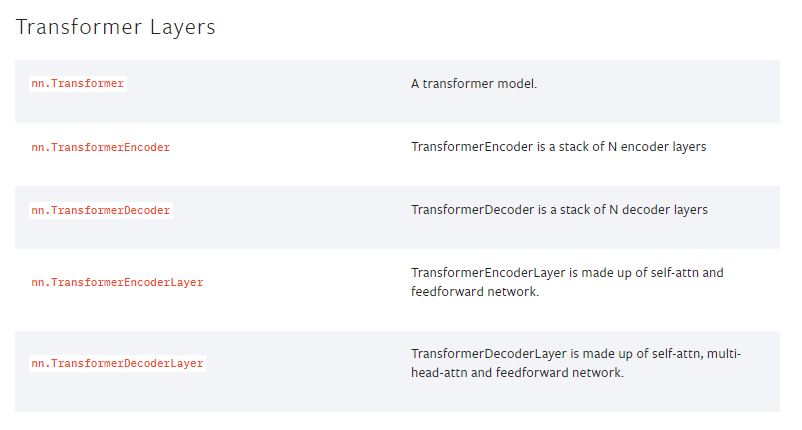

In [34]:
class TransformerModel(nn.Module) :
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.ninp = ninp
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.decoder = nn.Linear(ninp, ntoken) #논문하고 다른부분
        self.init_weights()
        
    # 정사각형의 attention mask 생성
    def generate_square_subsequent_mask(self, sz) :
        #triu = 행렬의 위쪽 삼각형 부분 (2 차원 텐서) 또는 행렬의 배치 input 을 반환
        #결과 텐서 out 의 다른 요소는 0으로 설정됩니다.
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0,1)
        mask = mask.float().masked_fill(mask==0, float('-inf')).masked_fill(mask==1, float(0.0))
        return mask
        
        
    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, src, src_mask) :
        src = self.encoder(src) * math.sqrt(self.ninp) #제곱근반환
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

### generate_square_subsequent_mask

In [26]:
sz = 3
a = torch.ones(sz, sz)
a

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [27]:
#렬의 위쪽 삼각형 부분 (2 차원 텐서) 또는 행렬의 배치 input 을 반환
torch.triu(torch.ones(sz, sz))

tensor([[1., 1., 1.],
        [0., 1., 1.],
        [0., 0., 1.]])

In [28]:
mask = (torch.triu(torch.ones(sz, sz))).transpose(0,1) #0 <-> 1차원 변경
mask

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [30]:
mask = mask.float().masked_fill(mask==0, float('-inf')) #0인거는 inf로 채우기 
mask

tensor([[1., -inf, -inf],
        [1., 1., -inf],
        [1., 1., 1.]])

In [31]:
mask = mask.masked_fill(mask==1, float(0.0)) #1인건 0으로 채우기
mask

tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])

In [35]:
math.sqrt(3)

1.7320508075688772